## Fifa 2018 Skills Challenge
Andrew Bond <br>
Aug 08, 2020

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

We need to load the data and clean it. The data is not encoded with 'utf-8' so we need to load find its encoding and use that instead

In [2]:
tempdata = open("Skills_Verification_Data_FIFA_18 (2) (1) (1) (1).csv")
print("The file's encoding is ",tempdata.encoding)
fifa_df = pd.read_csv(tempdata,encoding = 'cp1252', low_memory=False).dropna(how="all", inplace=False)
fifa_df.head()

The file's encoding is  cp1252


,No,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,0.0,158023.0,L. Messi,31.0,Argentina,94.0,94.0,FC Barcelona,€110.5M,$565,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,1.0,20801.0,Cristiano Ronaldo,33.0,Portugal,94.0,94.0,Juventus,€77M,$405,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,2.0,190871.0,Neymar Jr,26.0,Brazil,92.0,93.0,Paris Saint-Germain,€118.5M,$290,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,3.0,193080.0,De Gea,27.0,Spain,91.0,93.0,Manchester United,€72M,$260,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,4.0,192985.0,K. De Bruyne,27.0,Belgium,91.0,92.0,Manchester City,€102M,$355,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


We need to clean some of the data. A lot of columns contain data that can be converted to numerical.

In [3]:
fifa_df_clean = fifa_df.copy()
fifa_df_clean['Value'] = fifa_df_clean['Value'].replace('[\€M]', '', regex=True).astype(float)
fifa_df_clean['Wage'] = fifa_df_clean['Wage'].replace('[\$]', '', regex=True).astype(float)

fifa_df_clean["Height"] = fifa_df_clean["Height"].apply(lambda x: int(x.split("'")[0]) * 12 + int(x.split("'")[1]))

fifa_df_clean["Weight"] = fifa_df_clean["Weight"].replace('[lbs]','',regex=True).astype(float)

## Predicting 'Value' with Machine Learning Models

Before even building a model, we can find the features that are most likely to predict 'Value', these variables will have strong positive or negative correlations with 'Value', which indicates that they help explain the variance.

In [4]:
correlations = fifa_df_clean.corrwith(fifa_df_clean['Value']).sort_values(ascending=False)
print(correlations[abs(correlations) > 0.2])

Value                       1.000000
Overall                     0.833731
Potential                   0.777904
Wage                        0.754149
Reactions                   0.623651
International Reputation    0.423654
Composure                   0.395891
Finishing                   0.305001
Vision                      0.298988
Agility                     0.297495
Acceleration                0.281586
Positioning                 0.270860
Volleys                     0.268087
SprintSpeed                 0.258000
BallControl                 0.257387
LongShots                   0.252038
Penalties                   0.250978
ShortPassing                0.246763
Dribbling                   0.243432
FKAccuracy                  0.241397
Curve                       0.235706
Skill Moves                 0.231791
Balance                     0.225658
LongPassing                 0.210275
Age                        -0.220359
No                         -0.734687
dtype: float64


We sorted the correlations in descending order. Clearly 'Value' is perfectly correlated with 'Value', and strangely enough, No is also strongly negatively correlated with the 'Value'. This indicates the rows are in roughly descending order, but is not actually a sensible predictor of 'Value'. We will ignore 'No' and 'Value' and use every other attribute whose correlation is greater than 0.2.

In [5]:
features = correlations[abs(correlations) > 0.2].index
features = features.drop(['Value','No'])

Now we will make a new dataframe with the desired features, and another with the 'Value's. We will then perform our train test split to set aside some rows for validation after training the model.

In [6]:
from sklearn.model_selection import train_test_split
X = fifa_df_clean[features]
y = fifa_df_clean['Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=5)

#### Ordinary Least Square Regression
We will start by training an ordinary least squares regression model on the selected features. Since we are starting with Linear Regression, we are ignoring the variables that could be used categorically. It is possible to make use of them but not necessarily worth the time right off the bat. We could use techniques such as <b> one-hot encoding </b> to try to leverage them in our regression model, but we will not be doing that for now. We will also be using KFold cross-validation method reduce overfitting during training.

The mean R2 score during the training was  0.88486356105551


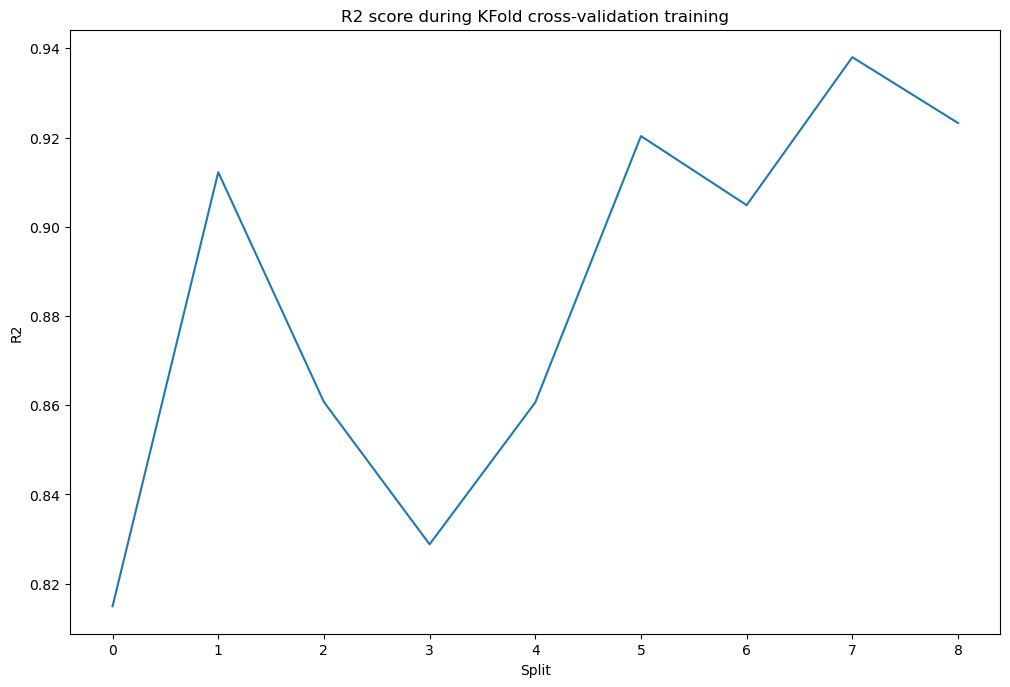

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

lr_model = LinearRegression()
r2_scores = []
kfold = KFold(n_splits = 9, shuffle=True, random_state=5)
for i, (train,test) in enumerate(kfold.split(X_train, y_train)):
    lr_model.fit(X_train.iloc[train,:], y_train.iloc[train])
    score = lr_model.score(X_train.iloc[test,:],y_train.iloc[test])
    r2_scores.append(score)
    
plt.plot(r2_scores)
plt.title('R2 score during KFold cross-validation training')
plt.xlabel('Split')
plt.ylabel('R2')

print("The mean R2 score during the training was ",np.array(r2_scores).mean())

Now we can validate the model on the withheld 'test' set.

In [8]:
validation_score = lr_model.score(X_test,y_test)
print('The R2 on the test set was ', validation_score)

The R2 on the test set was  0.919977904345087


This has a pretty good R2 value, but that just tells us that the regression model does a pretty good job representing the variance in the data set. 
## We can determine from the coefficients what the most important variable for prediction is: 

In [9]:
print("The most important feature for predicting 'Value' is ",features[np.argmax(lr_model.coef_)]," which has a coeffient of ",lr_model.coef_.max())

The most important feature for predicting 'Value' is  Overall  which has a coeffient of  5.691820876728239


There are other ways that we can assess the model performance.

In [10]:
import sklearn.metrics as metrics
y_train_pred = lr_model.predict(X_train)
y_pred = lr_model.predict(X_test)
print("RMSE:\n Train: ",np.sqrt(metrics.mean_squared_error(y_train,y_train_pred)),"Test: ",np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
print("Max Error:\n Train: ",metrics.max_error(y_train,y_train_pred),"Test: ",metrics.max_error(y_test,y_pred))
print("Mean Absolute Error:\n Train: ",metrics.mean_absolute_error(y_train,y_train_pred),"Test: ",metrics.mean_absolute_error(y_test,y_pred))

RMSE:
 Train:  4.982261013093777 Test:  4.259356249221708
Max Error:
 Train:  33.84808006416739 Test:  18.634921567114702
Mean Absolute Error:
 Train:  3.467346061156851 Test:  3.1036554658122224


These metrics tell us a little bit more about the performance of our model. The Root Mean Squared error tells us that the standard deviation of our residuals is 4.5 million Euros. The max error shows that the worst prediction we made was off by around 18.5 million(on the test set) and 33.5 million(on the training set) and finally, the Mean Absolute Error tells us that our literal mean error is around 3 million Euros. Scanning the data, these errors seem low in comparison to a lot of the 'Value's, but not all.
<br>
<br>
We can come up with another metric to assess the performance of our model, a heuristic approach. We will find the standard deviation of the 'Value' attribute and use it to give ourselves a threshold or tolerance for the error under which we will declare our model 'Accurate'.

In [11]:
value_std = fifa_df_clean.Value.std()
print("Standard deviation of the 'Value' variable: ",value_std)

Standard deviation of the 'Value' variable:  16.51781644769068


With this we could calculate our accuracy by determining what number of the predictions are within one standard deviation of their value, but I think we can be a little bit more stringent than that. We will calculate what percentage the standard deviation is of the maximum 'Value' and use that percentage error as our tolerance for accuracy.

In [12]:
max_value = fifa_df_clean.Value.max()
tolerance = value_std/max_value
print("Our tolerance will be ", tolerance*100, "%")

Our tolerance will be  13.939085609865554 %


In [13]:
residuals = (y_pred - y_test)
no_accurate = residuals[abs(residuals)/y_test <= tolerance].count()
print("With this new threshold tolerance for accuracy, we have an accuracy of: ",no_accurate/y_test.count()*100 , "%")

With this new threshold tolerance for accuracy, we have an accuracy of:  64.90066225165563 %


Not bad! With our Ordinary Least Squares regression model and our somewhat stringent metric, we managed to achieve an accuracy of ~65% using less than 25 variables. Our metric required that our prediction was within ~13.9% of the true value. Let's take a look at the values for which we weren't able to make this threshold.

The mean value of the wrong predictions is:  19.5188679245283
The threshold for the mean of the incorrect predictions is:  2.7207517100765877


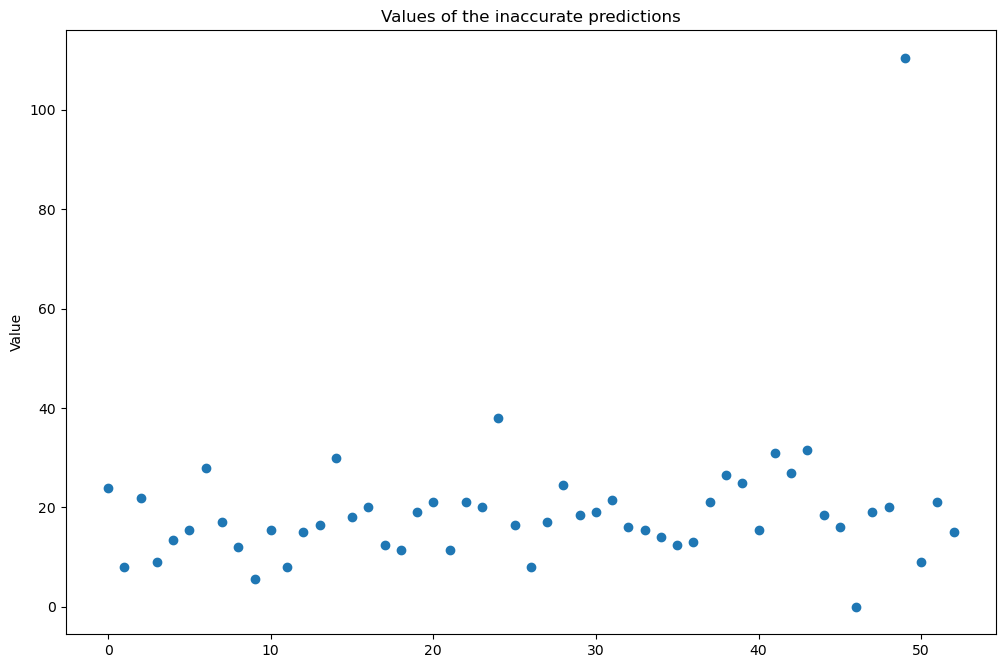

In [14]:
wrong = residuals[abs(residuals)/y_test > tolerance]
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(range(wrong.count()),y_test[wrong.index])
plt.title('Values of the inaccurate predictions')
plt.xlabel('')
plt.ylabel('Value')
print("The mean value of the wrong predictions is: ",y_test[wrong.index].mean())
print("The threshold for the mean of the incorrect predictions is: ",y_test[wrong.index].mean()*tolerance)

We should expect that the threshold would be harder to meet for the lower 'Value's. The mean of the missed values is 19.5 million, the threshold 13.9% for this mean is around 2.7 million. For a dataset that includes 'Value's over 100 million, this is pretty precise and its no surprise that the model couldn't manage accuracy on these players. This could potentially be addressed by categorical variables or by removing outliers. We will examine outliers such as "Superstars" later as a business question.

#### Decision Trees and more
We also want to try to take advantage of our categorical variables, which will require a little bit more cleaning to prepare. These variables can be very valuable to decision trees and algorithms like Ada Boost and Random Forests. We will use these and see how well they perform.

We start with the cleaning, I have identified some columns as great categorical candidates to inform our model:

In [15]:
fifa_df_clean["Nationality"] = fifa_df_clean["Nationality"].astype("category")
fifa_df_clean["Club"] = fifa_df_clean["Club"].astype("category")
fifa_df_clean["Preferred Foot"] = fifa_df_clean['Preferred Foot'].astype("category")

fifa_df_clean["Work Rate"] = fifa_df_clean["Work Rate"].astype("category")
fifa_df_clean["Position"] = fifa_df_clean["Position"].astype("category")

fifa_df_clean.insert(fifa_df_clean.columns.get_loc("Joined") + 1, "Joined (Month)", pd.DatetimeIndex(pd.to_datetime(fifa_df_clean["Joined"])).strftime("%b").astype('category'))
fifa_df_clean["Joined (Month)"] = fifa_df_clean["Joined (Month)"].cat.reorder_categories(['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul', 'Aug','Sep','Oct','Nov', 'Dec'])
fifa_df_clean["Joined (Month)"] = fifa_df_clean["Joined (Month)"].fillna('Jul')

fifa_df_clean.insert(fifa_df_clean.columns.get_loc("Joined") + 2, "Joined (Year)", pd.DatetimeIndex(pd.to_datetime(fifa_df_clean["Joined"])).year)
fifa_df_clean["Joined (Year)"] = fifa_df_clean["Joined (Year)"].fillna(2018)

We can take a look at a few of these variables and see if they have clear "classes" amongst them.

C:\Users\andyr\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


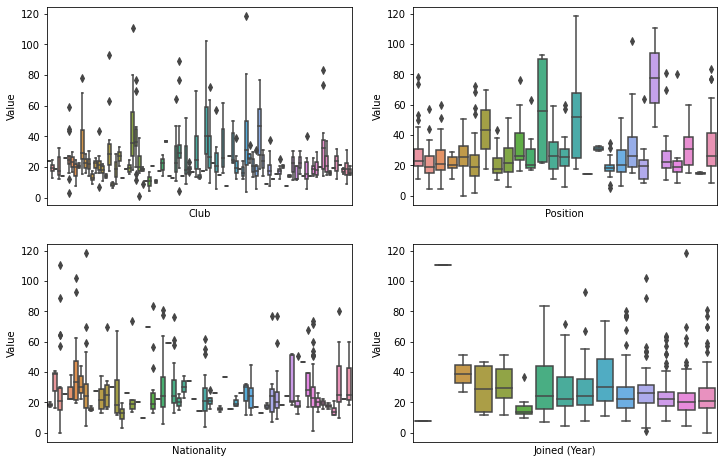

In [16]:
fig, ax = plt.subplots(2,2, figsize=(12,8))

for j in range(len(ax)):
    for i in range(len(ax[j])):
        ax[j][i].set_xlabel('label')

ax[0][0] = sns.boxplot(x="Club", y="Value", data=fifa_df_clean, ax=ax[0][0])
ax[1][0] = sns.boxplot(x="Nationality", y="Value", data=fifa_df_clean, ax=ax[1][0])
ax[0][1] = sns.boxplot(x="Position", y="Value", data=fifa_df_clean, ax=ax[0][1])
ax[1][1] = sns.boxplot(x="Joined (Year)", y="Value", data=fifa_df_clean, ax=ax[1][1])

for j in range(len(ax)):
    for i in range(len(ax[j])):
        ax[j][i].set_xticks([])

fig.show()

It does appear that we have some separate classes going on here. We can also see many of the outliers that probably caused us issues with the Linear Regression model. We will use the codes for the categories rather than the category names themselves.

In [17]:
fifa_df_clean["Nationality"] = fifa_df_clean["Nationality"].cat.codes
fifa_df_clean["Preferred Foot"] = fifa_df_clean["Preferred Foot"].cat.codes
fifa_df_clean["Work Rate"] = fifa_df_clean["Work Rate"].cat.codes
fifa_df_clean["Position"] = fifa_df_clean["Position"].cat.codes
fifa_df_clean["Joined (Month)"] = fifa_df_clean["Joined (Month)"].cat.codes
fifa_df_clean["Club"] = fifa_df_clean["Club"].cat.codes

We are also going to include the variables that have the good correlation with 'Value'.

In [18]:
features = features.append(pd.Index(['Nationality','Preferred Foot','Work Rate','Position','Joined (Month)','Club']))
X_dt = fifa_df_clean[features]
y_dt = fifa_df_clean['Value']
X_dt_train, X_dt_test, y_dt_train, y_dt_test = train_test_split(X_dt, y_dt, test_size = 0.3, random_state=5)

We are going to use Decision Trees, the most basic. Ada Boost to provide a refined Decision Tree with more and more accurate classes and a Random Forest.

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

In [20]:
def train_trees(max_depth, n_estimators, random_state):
    dtmodel = DecisionTreeRegressor(max_depth = max_depth)
    abmodel = AdaBoostRegressor(DecisionTreeRegressor(max_depth = max_depth), n_estimators = n_estimators, random_state = random_state)
    rfmodel = RandomForestRegressor(max_depth=max_depth, random_state = random_state)
    
    dtmodel.fit(X_dt_train, y_dt_train)
    abmodel.fit(X_dt_train, y_dt_train)
    rfmodel.fit(X_dt_train, y_dt_train)
    
    dtscore = dtmodel.score(X_dt_test,y_dt_test)
    abscore = abmodel.score(X_dt_test,y_dt_test)
    rfscore = rfmodel.score(X_dt_test,y_dt_test)
    
    return (dtmodel,abmodel,rfmodel,dtscore,abscore,rfscore)

In [21]:
dtscores = []
abscores = []
rfscores = []
labels = []
for i in range(3,16):
    for j in np.arange(200, 351, 50):
        (_,_,_,dts,abs,rfs) = train_trees(i, j, 5)
        labels.append(str(i)+','+str(j))
        dtscores.append(dts)
        abscores.append(abs)
        rfscores.append(rfs)

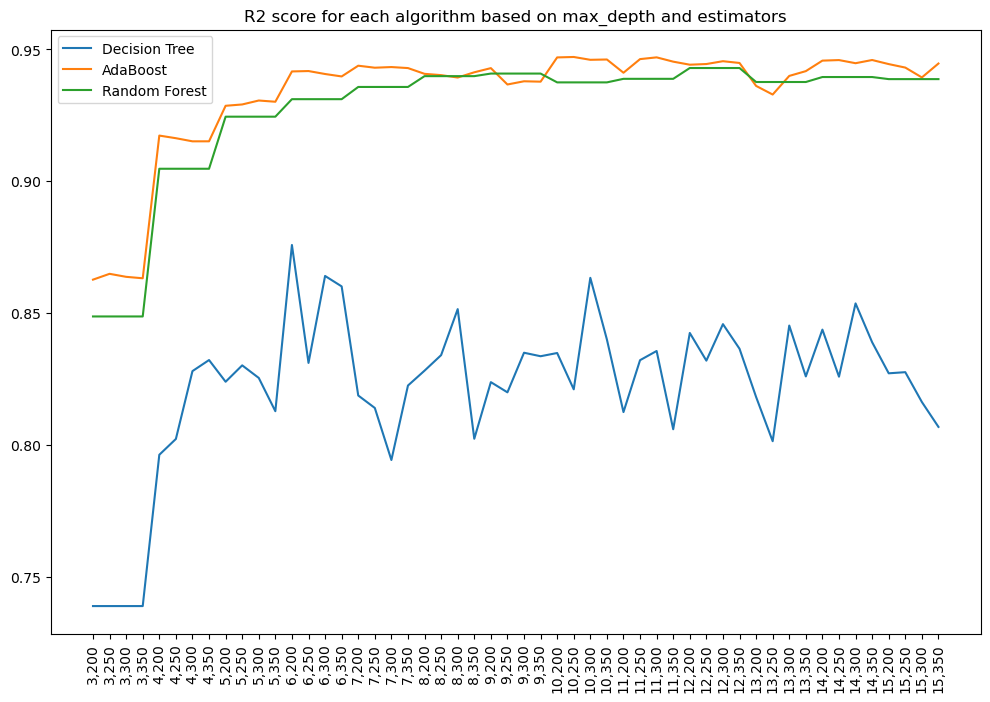

In [22]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(labels,dtscores)
plt.plot(labels,abscores)
plt.plot(labels,rfscores)
plt.title("R2 score for each algorithm based on max_depth and estimators")
plt.legend(["Decision Tree","AdaBoost","Random Forest"])
locs, lab = plt.xticks()
plt.setp(lab, rotation=90);

AdaBoost and the Random Forest level out for the most part sowe will choose one of the options for AdaBoost that spikes around a max_depth of 13, say 13,250

In [23]:
(_,ab,_,_,_,_) = train_trees(13,250,5)
y_ab_train_pred = ab.predict(X_dt_train)
y_ab_pred = ab.predict(X_dt_test)
print("RMSE:\n Train: ",np.sqrt(metrics.mean_squared_error(y_dt_train,y_ab_train_pred)),"Test: ",np.sqrt(metrics.mean_squared_error(y_dt_test,y_ab_pred)))
print("Max Error:\n Train: ",metrics.max_error(y_dt_train,y_ab_train_pred),"Test: ",metrics.max_error(y_dt_test,y_ab_pred))
print("Mean Absolute Error:\n Train: ",metrics.mean_absolute_error(y_dt_train,y_ab_train_pred),"Test: ",metrics.mean_absolute_error(y_dt_test,y_ab_pred))

RMSE:
 Train:  0.43728182580772934 Test:  3.9020154513592082
Max Error:
 Train:  2.5 Test:  20.0
Mean Absolute Error:
 Train:  0.16486263736263737 Test:  2.225953105423304


The results above make are suspicious of some overfitting, but the metrics are still pretty good, we will move on to calculating our heuristic.

In [24]:
residuals_ab = (y_ab_pred - y_dt_test)
no_accurate_ab = residuals_ab[np.abs(residuals_ab)/y_dt_test <= tolerance].count()
print("With this new threshold tolerance for accuracy, we have an accuracy of: ",no_accurate_ab/y_dt_test.count()*100 , "%")

With this new threshold tolerance for accuracy, we have an accuracy of:  82.11920529801324 %


With this method we got an accuracy of 82%, which is quite good! To improve this score we could also spent some time playing around with features, and investigating the possibility of overfitting as possibly indicated from the features above. We will determine the most important feature really quickly.
## The most important features for prediction are:

In [25]:
top_features = np.array(ab.feature_importances_).argsort()[::-1][:5]
print("The top 5 features are:")
for i in range(len(top_features)):
    print(features[top_features[i]])

The top 5 features are:
Potential
Overall
Reactions
Wage
Age


Like before we will look at the Values of the rows that we mis-predicted.

The mean value of the wrong predictions is:  25.925925925925927
The threshold for the mean of the incorrect predictions is:  3.6138370099651436


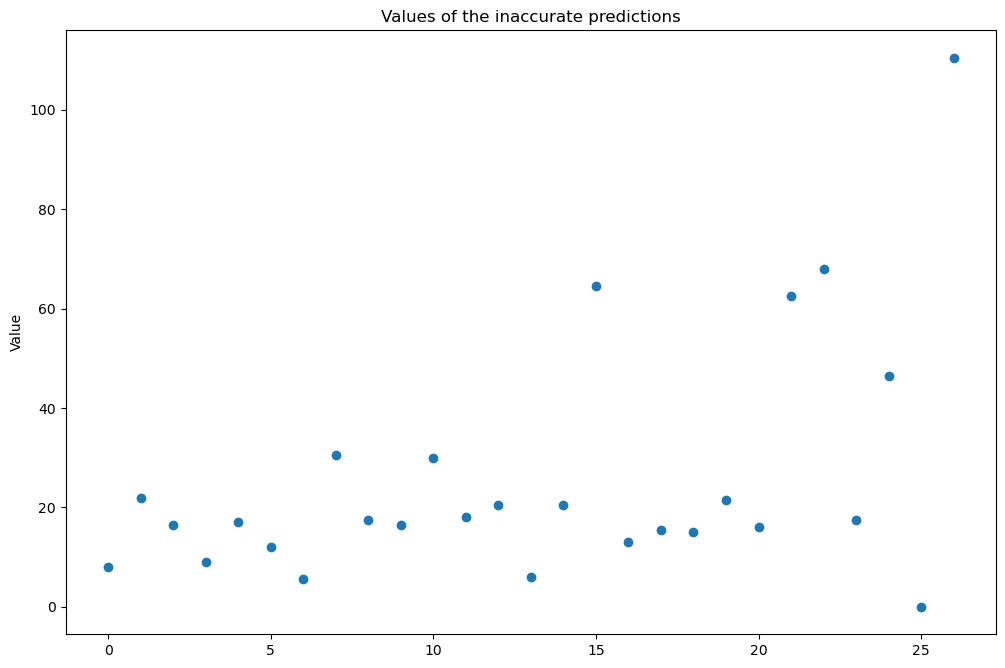

In [26]:
wrong_ab = residuals_ab[np.abs(residuals_ab)/y_dt_test > tolerance]
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(range(wrong_ab.count()),y_dt_test[wrong_ab.index])
plt.title('Values of the inaccurate predictions')
plt.xlabel('')
plt.ylabel('Value')
print("The mean value of the wrong predictions is: ",y_dt_test[wrong_ab.index].mean())
print("The threshold for the mean of the incorrect predictions is: ",y_dt_test[wrong_ab.index].mean()*tolerance)

While we have much fewer inaccurate predictions, the average is a bit higher and we see some errors right in the middle range. With more time we could take a look at why this is happening. It also seems that accounting for outliers may help quite a bit with the training of these models as well. We could also take a look at other models for the regression problem, or penalties such as Ridge, Lasso or Elastic Net. We could also examine the bias versus the variance in our models to try to find the right balance. But for now, this is all we are going to do when it comes to the prediction of Value.

## Data Exploration and Business Questions
While cleaning the data for the machine learning models, I became interested in the effects of the classes such as 'Club'. I think that a good starting place for exploration and an appropriate Business question is, "How do 'Value's distribute amongst these Clubs". With that in mind we will start splitting up the data and visualizing it. To examine this question, we will create a new attribute,  $VpW = \frac{Value}{Wage}$ which can help us identify business value of a player.
<br>
We also need to bring our categories back to make sense of what we see.

In [27]:
fifa_df_clean['VpW'] = fifa_df_clean['Value']/fifa_df_clean['Wage']
fifa_df_clean["Nationality"] = fifa_df["Nationality"].astype("category")
fifa_df_clean["Club"] = fifa_df["Club"].astype("category")
fifa_df_clean["Preferred Foot"] = fifa_df['Preferred Foot'].astype("category")

fifa_df_clean["Work Rate"] = fifa_df["Work Rate"].astype("category")
fifa_df_clean["Position"] = fifa_df["Position"].astype("category")

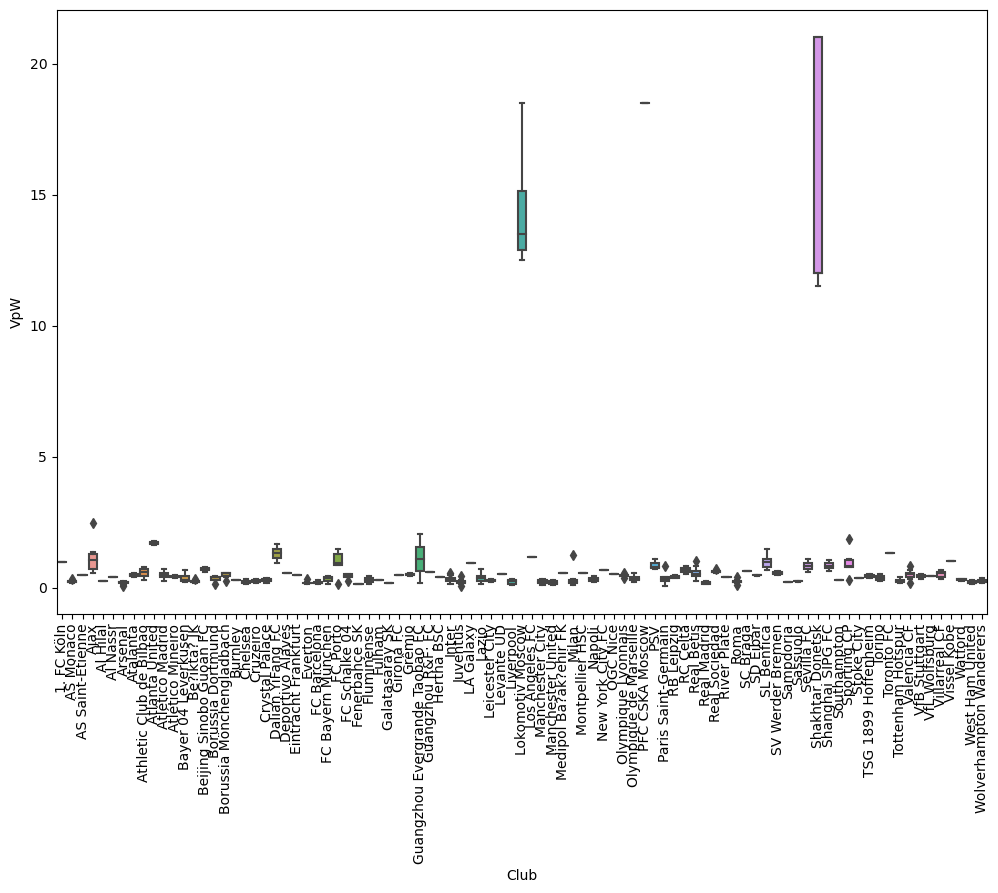

In [28]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
sns.boxplot(x="Club", y="VpW", data=fifa_df_clean)
locs, lab = plt.xticks()
plt.setp(lab, rotation=90);

Clearly something fishy is going on here, we can look at the data to find out why these Clubs have such a atypical distribution of VpW's

In [29]:
clubs = (fifa_df_clean['Club'] == "Shakhtar Donetsk") |  (fifa_df_clean['Club'] == "Lokomotiv Moscow")
df_vpw_outliers = fifa_df_clean[clubs]
df_vpw_outliers.Wage

286    1.0
288    1.0
301    1.0
381    1.0
386    1.0
405    1.0
453    1.0
473    1.0
484    1.0
Name: Wage, dtype: float64

Well, it appears that some of these clubs are not paying their players or don't release Wage information, it could also be clerical errors or perhaps autofilled due to lack of data. In reality, this would be a time to go talk to a subject matter expert and figure out what is going on with our data, but we will forge ahead with the assumption that we can hire the players for the wages given. Let's take a look if this lack of pay is related to Nationality.

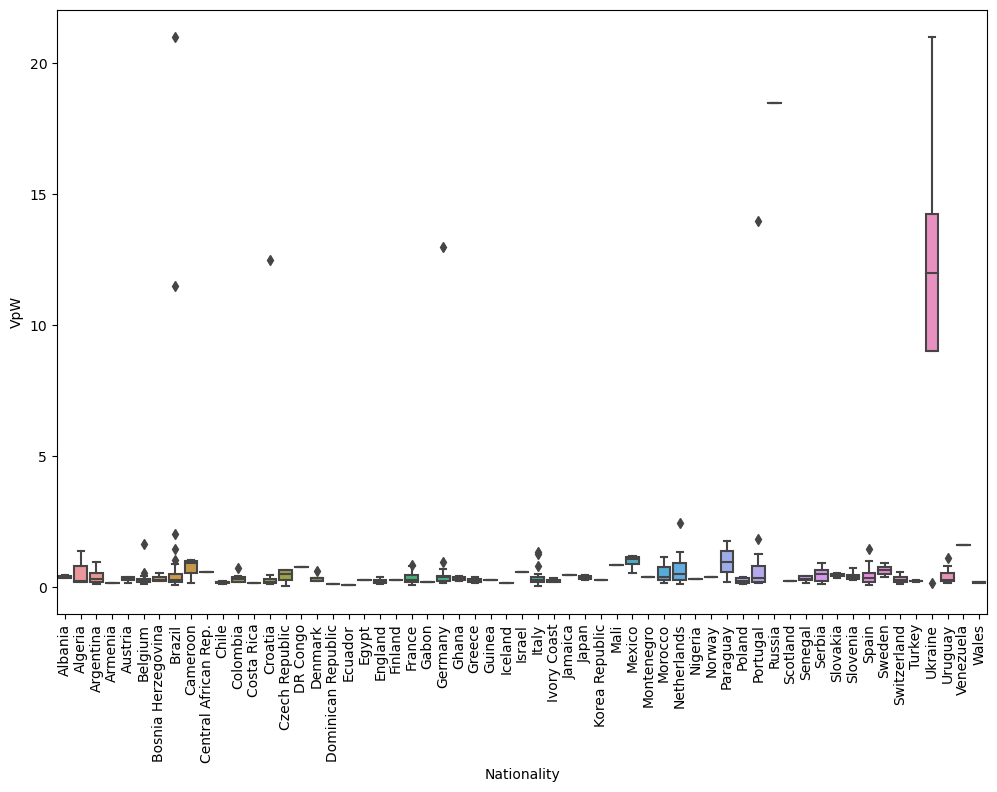

In [30]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
sns.boxplot(x="Nationality", y="VpW", data=fifa_df_clean)
locs, lab = plt.xticks()
plt.setp(lab, rotation=90);

In [31]:
countries = (fifa_df_clean['Nationality'] == "Ukraine") |  (fifa_df_clean['Nationality'] == "Russia")
df_vpw_outliers = fifa_df_clean[clubs]
df_vpw_outliers.Wage

286    1.0
288    1.0
301    1.0
381    1.0
386    1.0
405    1.0
453    1.0
473    1.0
484    1.0
Name: Wage, dtype: float64

We found the same indices by looking at wages for Ukraine and Russia, so it seems like these anomolies in the data are related to the country that the player is from. I don't think we can do any more with these underpaid players without more background information so instead we will try to figure out what is going on with the other outliers.

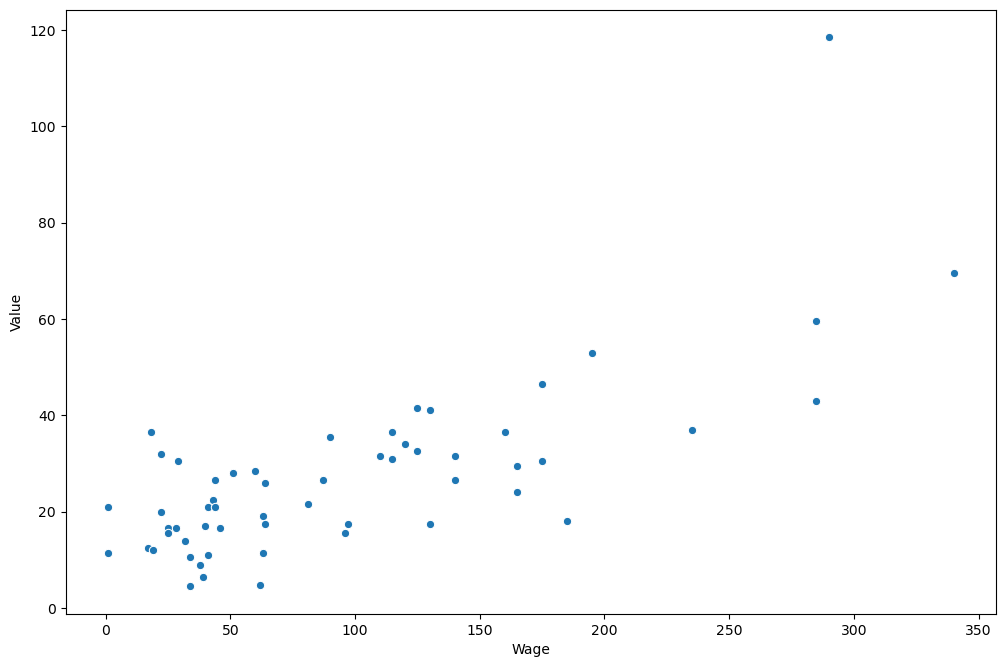

In [32]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
outliers = fifa_df_clean['Nationality'] == "Brazil"
df_vpw_outliers = fifa_df_clean[outliers]
sns.scatterplot(x ='Wage', y='Value', data = df_vpw_outliers)

Once again, it seems like we have some underpaid players. My guess is that unless we eliminate these ridiculously low wages, we would use this data to put together a team of players whose cost is not representative of reality. We could use a Linear Regression model or other Machine Learning model trained on the players whose Wage is greater than 1, and reassign Wage for the players. For the sake of time we will just remove the players whose Wage is 1.

In [33]:
fifa_df_wage = fifa_df_clean[fifa_df_clean['Wage'] > 1]
print(len(fifa_df_wage))

490


Now that we got rid of those irrationally paid players, we will look at Clubs again.

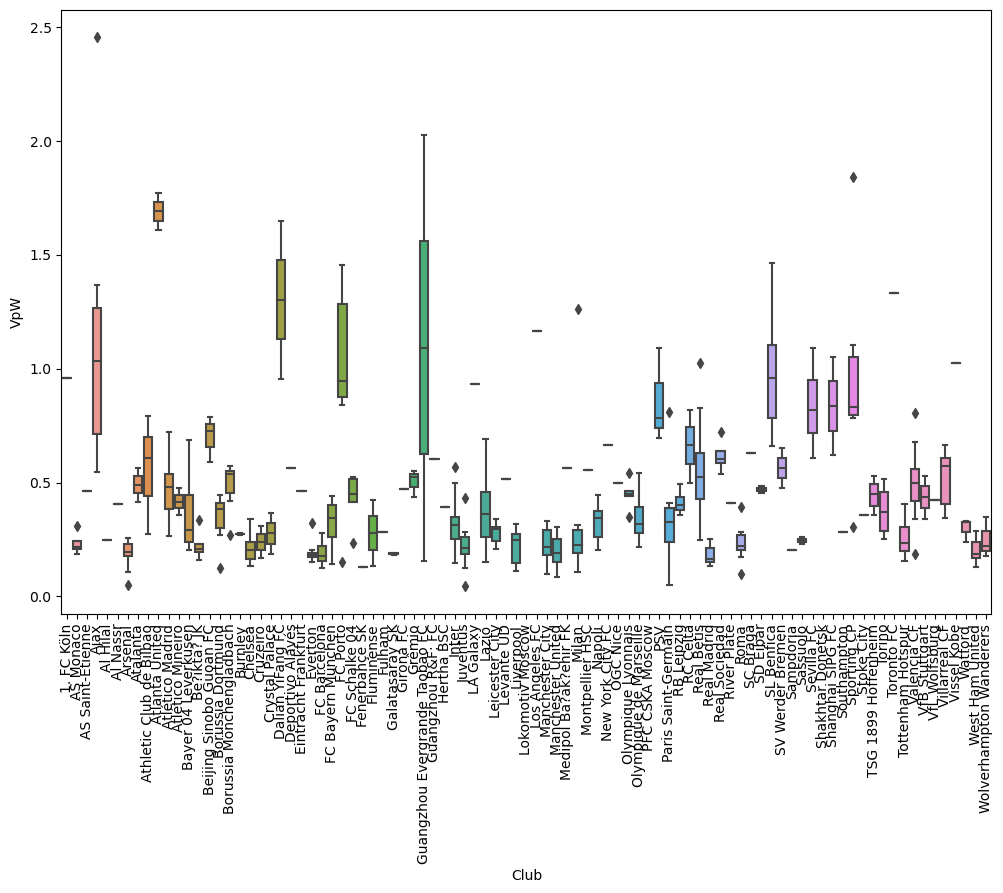

In [34]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
sns.boxplot(x="Club", y="VpW", data=fifa_df_wage)
locs, lab = plt.xticks()
plt.setp(lab, rotation=90);

Things look a lot more interesting now, and it is clear that the Clubs have very different distributions of VpW. Since there are 23 players on a FIFA team (I looked it up) let's take a look at the top 23 'VpW' players and their wages.

In [35]:
top_vpw = fifa_df_wage.sort_values(by=['VpW'], ascending=False).iloc[:23]
top_vpw[['Name','Wage','VpW','Value']]

,Name,Wage,VpW,Value
226,M. de Ligt,11.0,2.454545,27.0
166,Anderson Talisca,18.0,2.027778,36.5
114,Bruno Fernandes,22.0,1.840909,40.5
418,M. Almirón,11.0,1.772727,19.5
173,Y. Carrasco,20.0,1.650000,33.0
345,J. Martínez,14.0,1.607143,22.5
342,Grimaldo,14.0,1.464286,20.5
112,Alex Telles,22.0,1.454545,32.0
94,Y. Brahimi,28.0,1.392857,39.0
323,F. de Jong,19.0,1.368421,26.0


In [36]:
print("Using our top 23 VpW players, we get a team that costs us: ")
print("$",top_vpw['Wage'].sum())
print("This budget team gives us a Value of: ")
print(top_vpw['Value'].sum()," million Euros")

Using our top 23 VpW players, we get a team that costs us: 
$ 450.0
This budget team gives us a Value of: 
608.5  million Euros


For less than a single one of the "superstars", we can get a value of 608.5 million Euros, probably 6 times the value of a superstar...but that is our entire team. Great on a budget, but could we actually win any games? We can't answer that question with our data, but we can certainly look at our "Overall" scores and whether we even have the right players for the positions we need! Before we look at our team, lets get an idea of what the "Overall" scores look like amongst our data. We also should take a look what what positions we need to put together a legitimate team.

The mean 'Overall' score of a player in our data is:  82.8942115768463


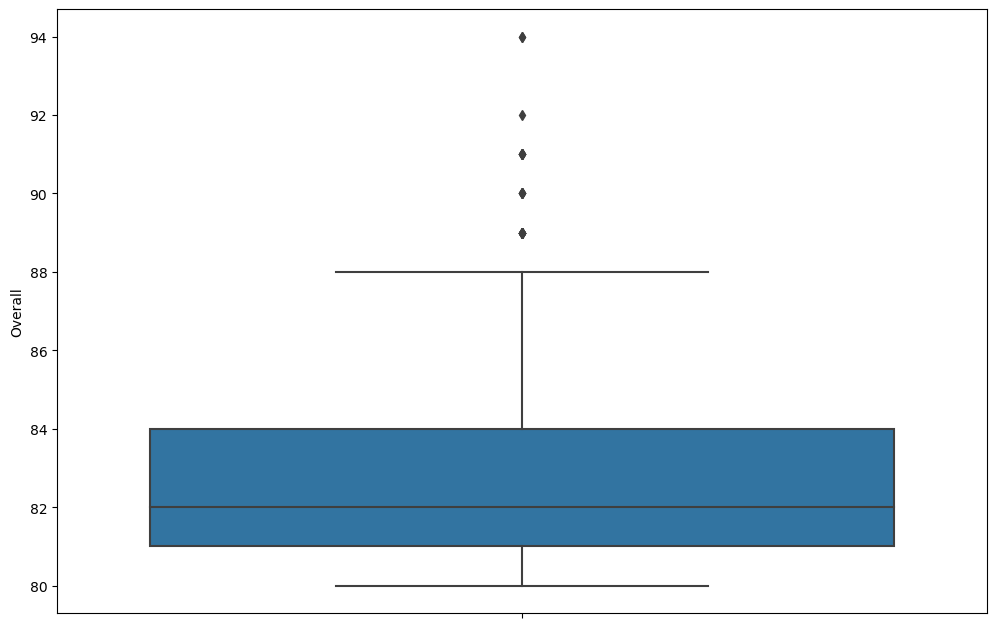

In [37]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
sns.boxplot(y="Overall", data=fifa_df_clean)
locs, lab = plt.xticks()
plt.setp(lab, rotation=90);
print("The mean 'Overall' score of a player in our data is: ",fifa_df_clean.Overall.mean())

So, the average for players in our data is right around 82. Next, we look into team compositions and viable team strategies. I used the following site<br> <a href="https://protips.dickssportinggoods.com/sports-and-activities/soccer/soccer-positions-the-numbers-player-roles-basic-formations">Soccer Team Composition</a>.
<br>
With what we know, lets take a look at our "Budget" team.

In [38]:
print("Our team's mean 'Overall' score is: ", top_vpw.Overall.mean())
top_vpw[['Name','Position','Overall']]

Our team's mean 'Overall' score is:  82.08695652173913


,Name,Position,Overall
226,M. de Ligt,RCB,82.0
166,Anderson Talisca,CAM,83.0
114,Bruno Fernandes,LCM,84.0
418,M. Almirón,CAM,80.0
173,Y. Carrasco,LM,83.0
345,J. Martínez,LS,81.0
342,Grimaldo,LB,81.0
112,Alex Telles,LB,84.0
94,Y. Brahimi,LM,85.0
323,F. de Jong,LDM,81.0


Already, we know that our team is slightly below average. As for player positions, we have a bunch of Acronyms, lets use the categories from the link above to analyze if we can manage to put together a '4-3-3' or '4-4-2' formation.
<br>For Defensive Positions we have ['CB','LB','RB','LWB','RWB','SW']
<br>For Midfield Positions we have ['DM','CM','AM','LM','RM']
<br>For Offensive Positions we have ['CF','S','SS']
<br>And we always need a ['GK']
<br>
Let's make a new column to label our players.

In [39]:
defensive = ['CB','LB','RB','LWB','RWB','SW']
midfield = ['DM','CM','AM','LM','RM']
offensive = ['CF','S','SS'] 
offMid = ['RW','LW','LF','RF']
# I added wings(RW, LW, LF, RF) after looking at https://www.fifauteam.com/fifa-ultimate-team-positions-and-tactics/
goalkeeper = ['GK']
top_vpw['Position Type'] = top_vpw['Position'].apply(lambda x: "Defense" if any(pos in x for pos in defensive)
                                                                else "Midfield" if any(pos in x for pos in midfield)
                                                                else "Offensive" if any(pos in x for pos in offensive)
                                                                else "OffMid" if any(pos in x for pos in offMid)
                                                                else "Goalie" if "GK" in x
                                                                else "Error")

In [40]:
top_vpw[['Position','Position Type']]

,Position,Position Type
226,RCB,Defense
166,CAM,Midfield
114,LCM,Midfield
418,CAM,Midfield
173,LM,Midfield
345,LS,Offensive
342,LB,Defense
112,LB,Defense
94,LM,Midfield
323,LDM,Midfield


It looks like we can put together a team, but we would have no backup Defense players if we played a 4-x-x. We have a massive number of Midfielders, two Goalies and five Offensive players. I think we could probably put together a lot better team composition and probably achieve a better 'Overall' score as well. <br>
For our next business question, we are going to take a closer look at positions and put together a team based on a proposed composition.

In [41]:
fifa_df_clean['Position Type'] = fifa_df_clean['Position'].apply(lambda x: "Defense" if any(pos in x for pos in defensive)
                                                                else "Midfield" if any(pos in x for pos in midfield)
                                                                else "Offensive" if any(pos in x for pos in offensive)
                                                                else "OffMid" if any(pos in x for pos in offMid)
                                                                else "Goalie" if "GK" in x
                                                                else "Error")
fifa_df_positions = fifa_df_clean[fifa_df_clean.Wage > 1]

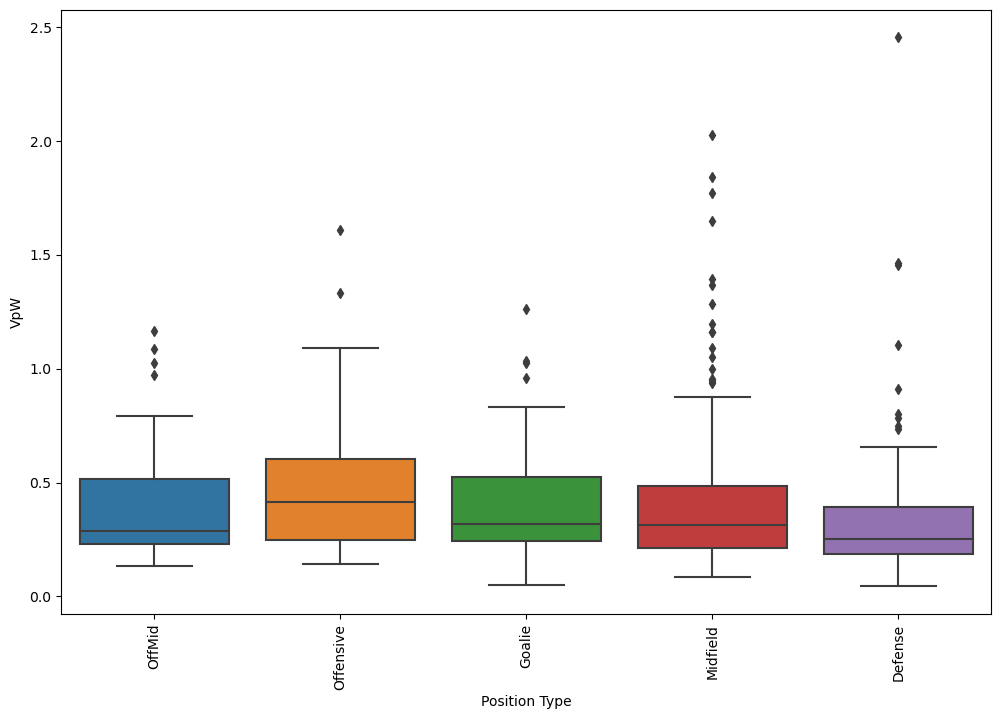

In [42]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
sns.boxplot(x="Position Type", y="VpW", data=fifa_df_positions)
locs, lab = plt.xticks()
plt.setp(lab, rotation=90);

Let's put together a team! We want to grab the top 5 dedicated Offense, the top 4 dedicated Midfield, the top 4 Offensive/Midfield, the top 7 Defensive, and the top 3 Goalies. 

In [43]:
offMid_df = fifa_df_positions[fifa_df_positions["Position Type"] == "OffMid"]
offensive_df = fifa_df_positions[fifa_df_positions["Position Type"] == "Offensive"]
midfield_df = fifa_df_positions[fifa_df_positions["Position Type"] == "Midfield"]
defensive_df = fifa_df_positions[fifa_df_positions["Position Type"] == "Defense"]
goalie_df = fifa_df_positions[fifa_df_positions["Position Type"] == "Goalie"]
top_OffMid = offMid_df.sort_values(by=['VpW'], ascending=False).iloc[:4]
top_offensive = offensive_df.sort_values(by=['VpW'], ascending=False).iloc[:5]
top_defensive = defensive_df.sort_values(by=['VpW'], ascending=False).iloc[:7]
top_midfield = midfield_df.sort_values(by=['VpW'], ascending=False).iloc[:4]
top_goalie = goalie_df.sort_values(by=['VpW'], ascending=False).iloc[:3]
our_team = top_OffMid.append([top_offensive, top_defensive,top_midfield,top_goalie])
our_team

,No,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,...,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,VpW,Position Type
397,397.0,169416.0,C. Vela,29.0,Mexico,81.0,81.0,Los Angeles FC,17.5,15.0,...,31.0,22.0,14.0,8.0,14.0,8.0,13.0,10.0,1.166667,OffMid
436,436.0,216547.0,Rafa,25.0,Portugal,80.0,83.0,SL Benfica,18.5,17.0,...,23.0,38.0,31.0,9.0,11.0,11.0,12.0,8.0,1.088235,OffMid
76,76.0,41.0,Iniesta,34.0,Spain,86.0,86.0,Vissel Kobe,21.5,21.0,...,67.0,57.0,56.0,6.0,13.0,6.0,13.0,7.0,1.023810,OffMid
375,375.0,190972.0,E. Salvio,27.0,Argentina,81.0,81.0,SL Benfica,18.5,19.0,...,49.0,60.0,56.0,9.0,11.0,9.0,5.0,14.0,0.973684,OffMid
345,345.0,207877.0,J. Martínez,25.0,Venezuela,81.0,84.0,Atlanta United,22.5,14.0,...,20.0,20.0,15.0,12.0,14.0,14.0,12.0,8.0,1.607143,Offensive
293,293.0,184431.0,S. Giovinco,31.0,Italy,82.0,82.0,Toronto FC,20.0,15.0,...,23.0,29.0,28.0,6.0,3.0,6.0,3.0,3.0,1.333333,Offensive
329,329.0,221992.0,H. Lozano,22.0,Mexico,81.0,86.0,PSV,24.0,22.0,...,45.0,35.0,29.0,11.0,10.0,14.0,14.0,10.0,1.090909,Offensive
204,204.0,189068.0,B. Dost,29.0,Netherlands,83.0,83.0,Sporting CP,26.0,26.0,...,38.0,45.0,26.0,6.0,12.0,15.0,11.0,8.0,1.000000,Offensive
480,480.0,199069.0,V. Aboubakar,26.0,Cameroon,80.0,82.0,FC Porto,18.0,19.0,...,44.0,23.0,19.0,8.0,10.0,9.0,7.0,8.0,0.947368,Offensive
226,226.0,235243.0,M. de Ligt,18.0,Netherlands,82.0,91.0,Ajax,27.0,11.0,...,84.0,84.0,79.0,12.0,11.0,11.0,12.0,10.0,2.454545,Defense


In [44]:
print("Using our new team, we get a team that costs us: ")
print("$",our_team['Wage'].sum())
print("Which gives us a Value of: ")
print(our_team['Value'].sum()," million Euros")
print("Now our 'Overall' score is: ")
print("Our team's mean 'Overall' score is: ", our_team.Overall.mean())

Using our new team, we get a team that costs us: 
$ 416.0
Which gives us a Value of: 
526.0  million Euros
Now our 'Overall' score is: 
Our team's mean 'Overall' score is:  81.78260869565217


Oh no! Our 'Value', 'Overall' and even our cost went down, but we have the right players for the positions! <br>
Perhaps we should take into account "starters" and "relief" players, perhaps we could get more granular into positions and formations, develop teams around strategies we might have. Think of what we could do if we had more data such as team performance, full team player data and a subject matter expert to refer to for even more insight. At this point we could examine the traits like "Potential", create new attributes combining Potential and Overall, create an algorithm to maximize an attribute under a certain budget and more! We will stop here though, as this is a homework assignment for a job interview and I don't want to dive any further down the rabbit hole. Thanks for the fun, now I have to get back to working overtime this weekend for my current job!